# Calculate beam intensity and resolution vs FC freq

In [1]:
import os, numpy as np
import histogram.hdf as hh, histogram as H
import mcvine, mcvine.components, mcvine.run_script

from matplotlib import pyplot as plt
%matplotlib notebook

In [2]:
from mcni.utils import conversion as C

In [3]:
workdir = os.path.expanduser("/SNS/users/lj7/dv/sns-chops/resolution/ARCS/mcvine/Ei_500_FC1")
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/dv/sns-chops/resolution/ARCS/mcvine/Ei_500_FC1


# Function

T0_nu value: see check-V-data.ipynb

Be careful to choose dE_axis. The step size should be small enough

In [4]:
def run(
    freq=600., Ei=400., T0_nu=180., E=0., Q=5., 
    dQ_axis=(-5, 5, 0.05), dE_axis=(-50, 50, .2),
    fc = '700-1.5-SMI'
):
    """fc: 100-1.5-SMI, 700-1.5-SMI, 700-0.5-AST
    """
    pwd = os.path.abspath('.')
    beam_dir = os.path.abspath('beam-FC_%s_%s' % (fc, freq) )
    os.makedirs(beam_dir)
    os.chdir(beam_dir)
    cmd = "mcvine instruments arcs beam --T0_nu=%s --E=%s --fermi_chopper=%s --fermi_nu=%s --ncount=1e8 --nodes=20" % (
        T0_nu, Ei, fc, freq)
    print cmd
    if os.system(cmd):
        raise RuntimeError('%s failed' % cmd)
    os.chdir(pwd)
    
    instrument = 'ARCS'
    ncount = 1e6
    nodes = 10
    from dgsres.powder import  use_ConstantQEKernel
    sim = use_ConstantQEKernel.Sim(
        instrument = instrument,
        workdir = os.path.abspath("./resolution-FC_%s_%s" % (fc, freq)),
        beamdir = beam_dir,
        Ei = Ei,
        Q = Q,
        dQ_axis=dQ_axis,
        dE_axis=dE_axis,
        ncount = ncount,
        nodes = nodes,
        )
    sim.run(E=E)
    return

In [5]:
Ei = 500.

In [6]:
C.e2k(Ei)

15.533787415385476

In [7]:
E=0.; Q=7.

In [8]:
%%time
run(fc='700-1.5-SMI', Ei=Ei, freq=600., E=E, Q=Q)

mcvine instruments arcs beam --T0_nu=180.0 --E=500.0 --fermi_chopper=700-1.5-SMI --fermi_nu=600.0 --ncount=1e8 --nodes=20
CPU times: user 108 ms, sys: 32.3 ms, total: 140 ms
Wall time: 17min 34s


/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/histogram/hdf/Loader.py:129: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'storage' in list(dataGroup): # this uses the 'storage' convention


In [9]:
ls

beam-FC_700-1.5-SMI_600.0/  resolution-FC_700-1.5-SMI_600.0/


In [10]:
ls beam-FC_700-1.5-SMI_600.0/

arcs_moderator2sample.pml                    mon1-tof.dat
_m2sout/                                     mon2-tof.dat
mcvine-instruments-arcs-analyze_beam.params  out/
mcvine-instruments-arcs-beam.params          README.arcs_beam
mcvine-instruments-arcs-m2s.params           run-m2s.sh
mcvine-instruments-arcs-mod2sample.params


In [17]:
more beam-FC_700-1.5-SMI_600.0/arcs_moderator2sample.pml

In [12]:
ls resolution-FC_700-1.5-SMI_600.0/out/

ie-Q_7.0-E_0.0.h5  iqe-Q_7.0-E_0.0.h5


In [13]:
ie = hh.load('./resolution-FC_700-1.5-SMI_600.0/out/ie-Q_7.0-E_0.0.h5')

<IPython.core.display.Javascript object>


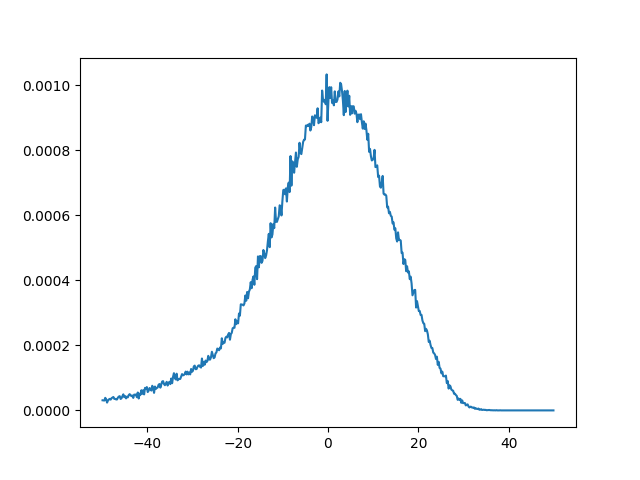

In [15]:
plt.figure()
plt.plot(ie.E, ie.I)

In [16]:
freqs = np.arange(120., 541., 60.)

** not run yet **

In [137]:
%%time
for freq in freqs:
    print freq
    run(fc='700-1.5-SMI', Ei=Ei, freq=600., E=E, Q=Q)

60.0
120.0
180.0
240.0
300.0
360.0
420.0
480.0
CPU times: user 692 ms, sys: 319 ms, total: 1.01 s
Wall time: 2h 20min 34s


# Gather resolution and intensity data
**Need modifications below to make it work !!!**

## Resolution

In [148]:
ls resolution-FC_120.0/res-sim/

beam@           log.reduce   README.md            sim.nxs
create-nxs*     log.reduce2  reduce2iqe*          sss*
debug-scatter*  log.scatter  sampleassembly/      sss.pml
iqe.h5          Makefile     scatter*             test-scatter*
log.create-nxs  out/         sim_no_metadata.nxs  work-arcs-neutrons2nxs/


In [138]:
freqs = np.arange(60., 601., 60.)

In [163]:
FWHMs = []
for freq in freqs:
    fn = 'resolution-FC_%s/out/ie-Q_%s-E_%s.h5' % (freq, Q, E)
    h = hh.load(fn)
    Is = h.I
    Es = h.E
    maxI = np.max(Is)
    upper = Es[Is > maxI/2.]
    FWHM = upper[-1] - upper[0]
    print FWHM
    FWHMs.append(FWHM)

65.4
33.4
27.2
24.0
22.0
22.0
20.6
21.8
20.4
19.0


<IPython.core.display.Javascript object>


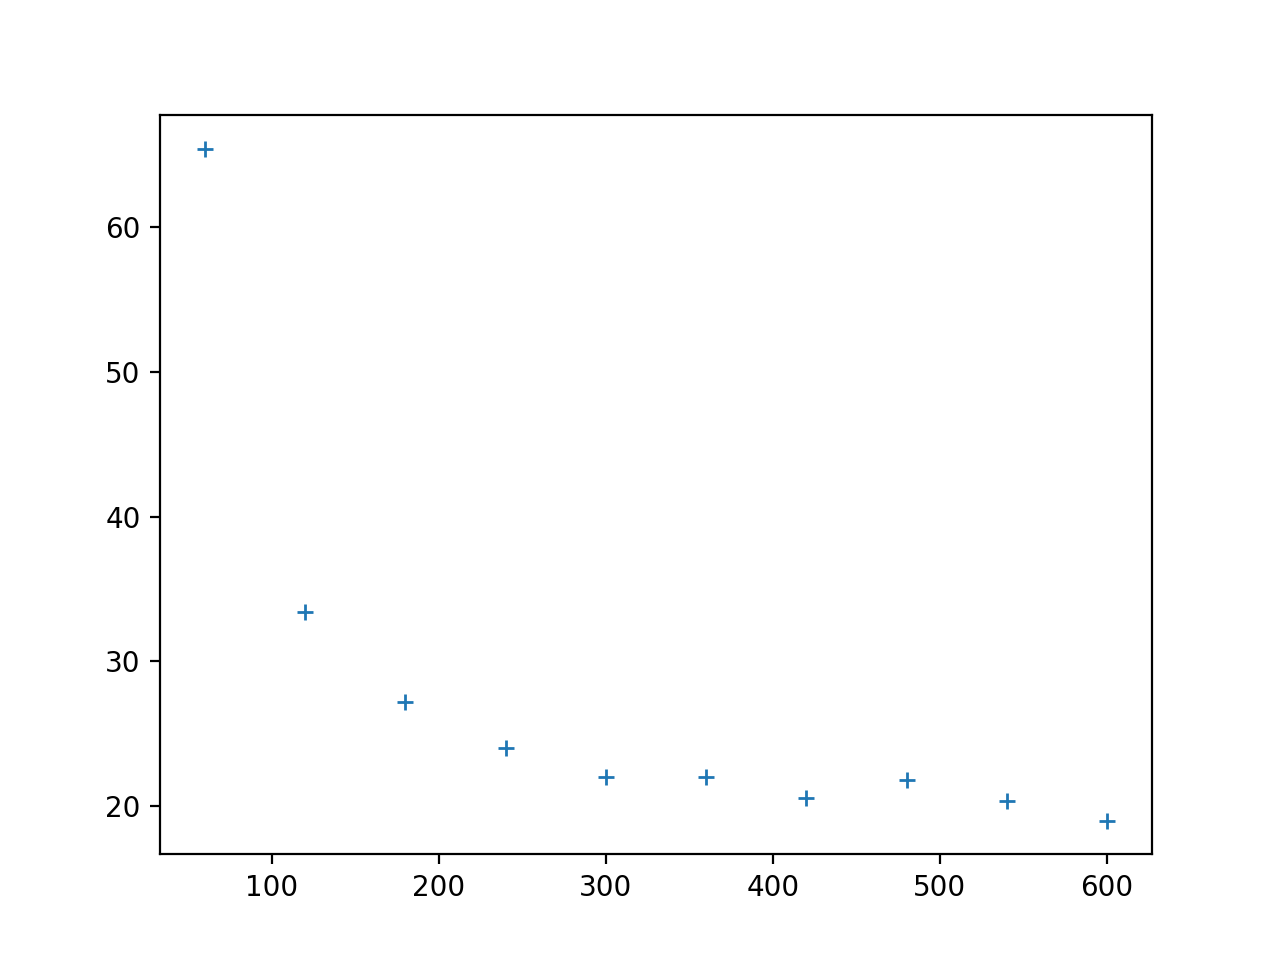

In [165]:
plt.figure()
plt.plot(freqs, FWHMs, '+')

The data at lower freq is large. Inspect

<IPython.core.display.Javascript object>


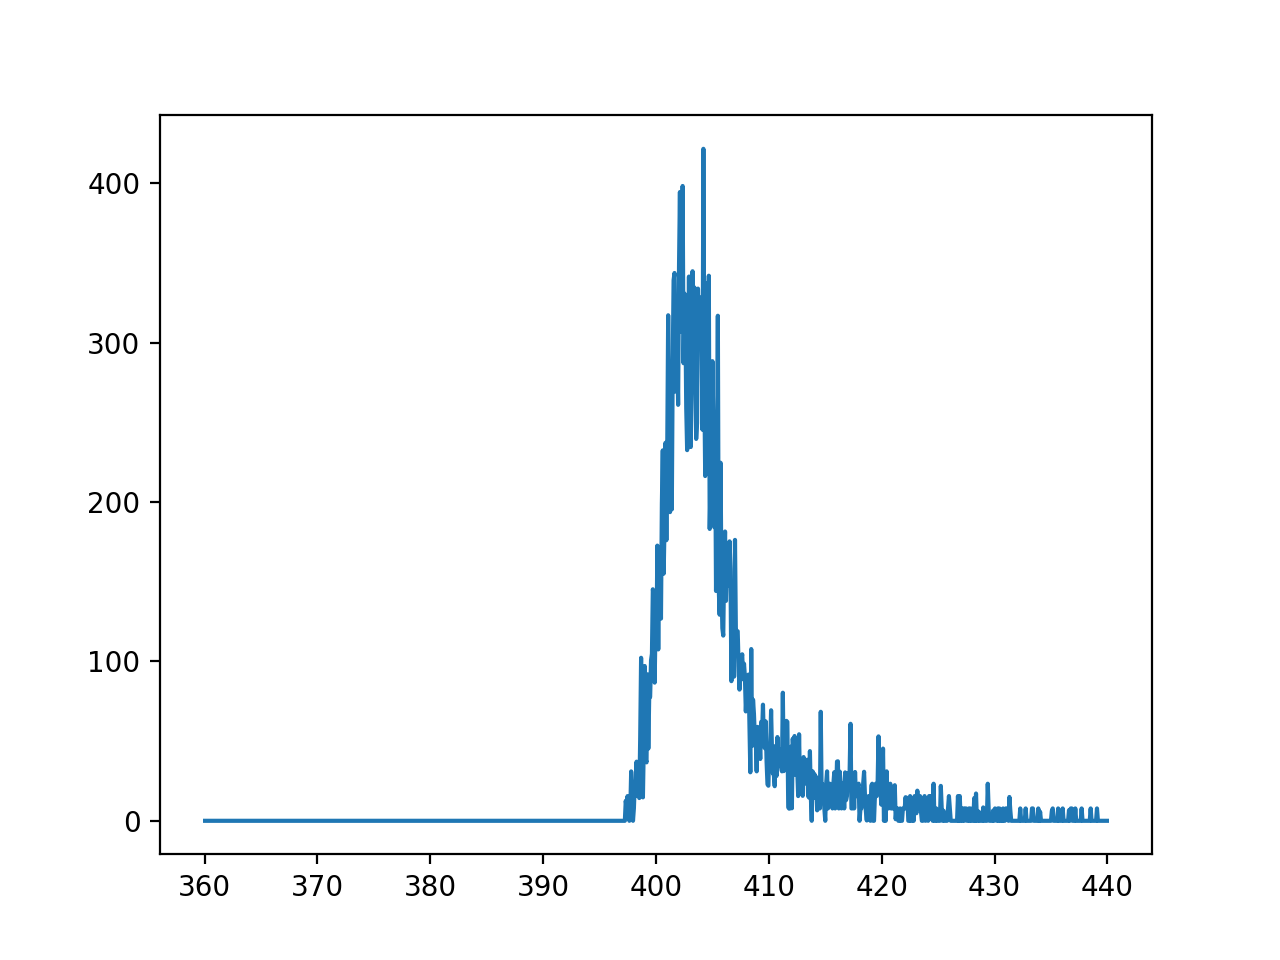

In [162]:
h = hh.load('beam-FC_180.0/out/ienergy.h5')
plt.figure()
plt.plot(h.energy, h.I)

<IPython.core.display.Javascript object>


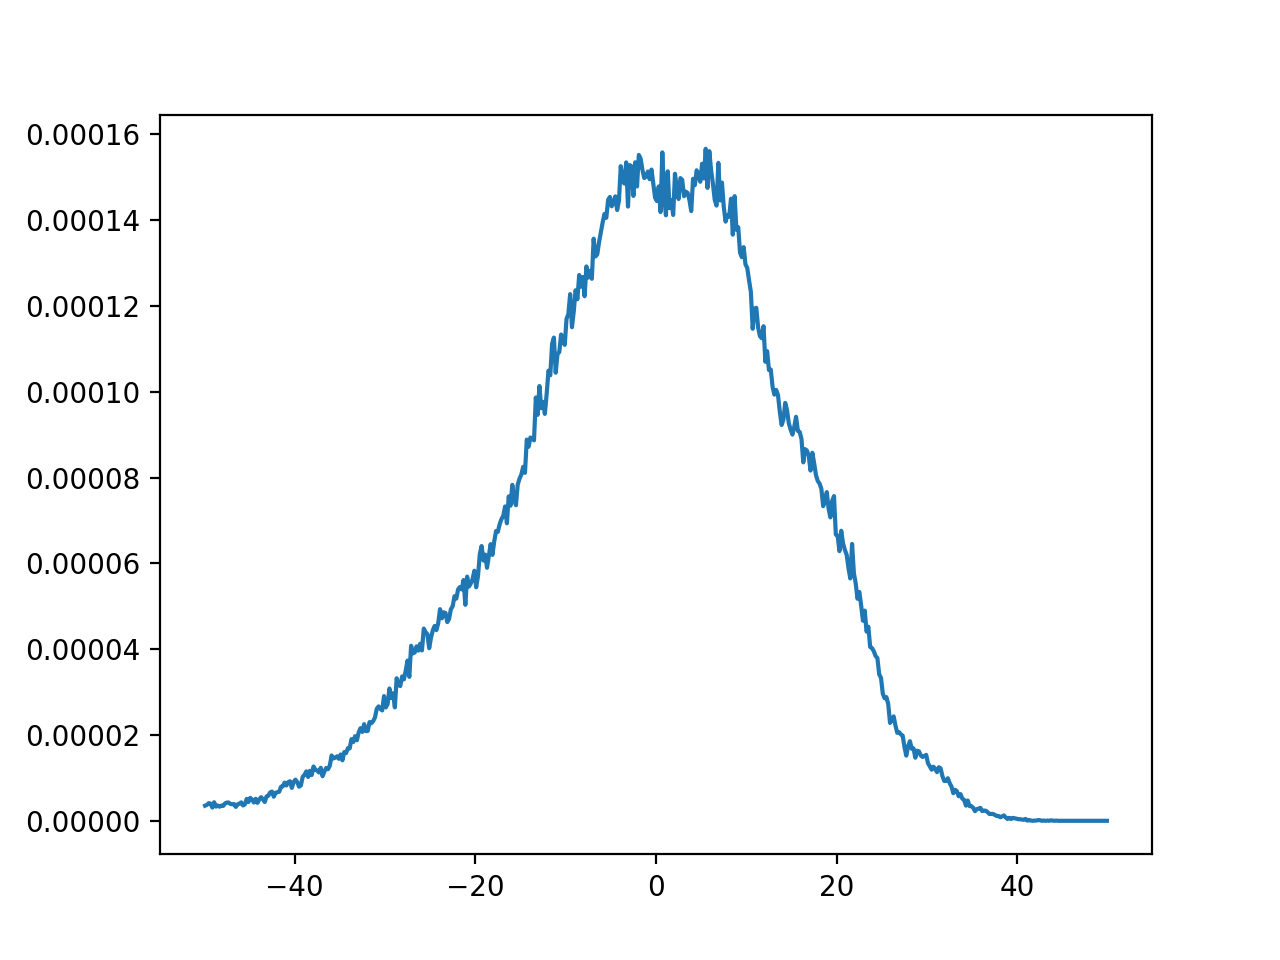

In [161]:
h = hh.load('resolution-FC_120.0/out/ie-Q_5.0-E_0.0.h5')
plt.figure()
plt.plot(h.E, h.I)

Looks like we need more statistics for lower freq

Was thinking to rerun some lower freqs, but the experimental data only goes down to 240Hz. So I guess we are OK.

## Intensity

In [166]:
ls beam-FC_120.0/out/

ienergy.h5  ix_divy.h5  iy_divy.h5            neutrons
itof.h5     ix_y.h5     mon1-itof-focused.h5  props.json
ix_divx.h5  iy_divx.h5  mon2-itof-focused.h5  rank0-step0/


In [167]:
counts = []
for freq in freqs:
    fn = 'beam-FC_%s/out/ienergy.h5' % (freq,)
    h = hh.load(fn)
    counts.append(h.I.sum())

<IPython.core.display.Javascript object>


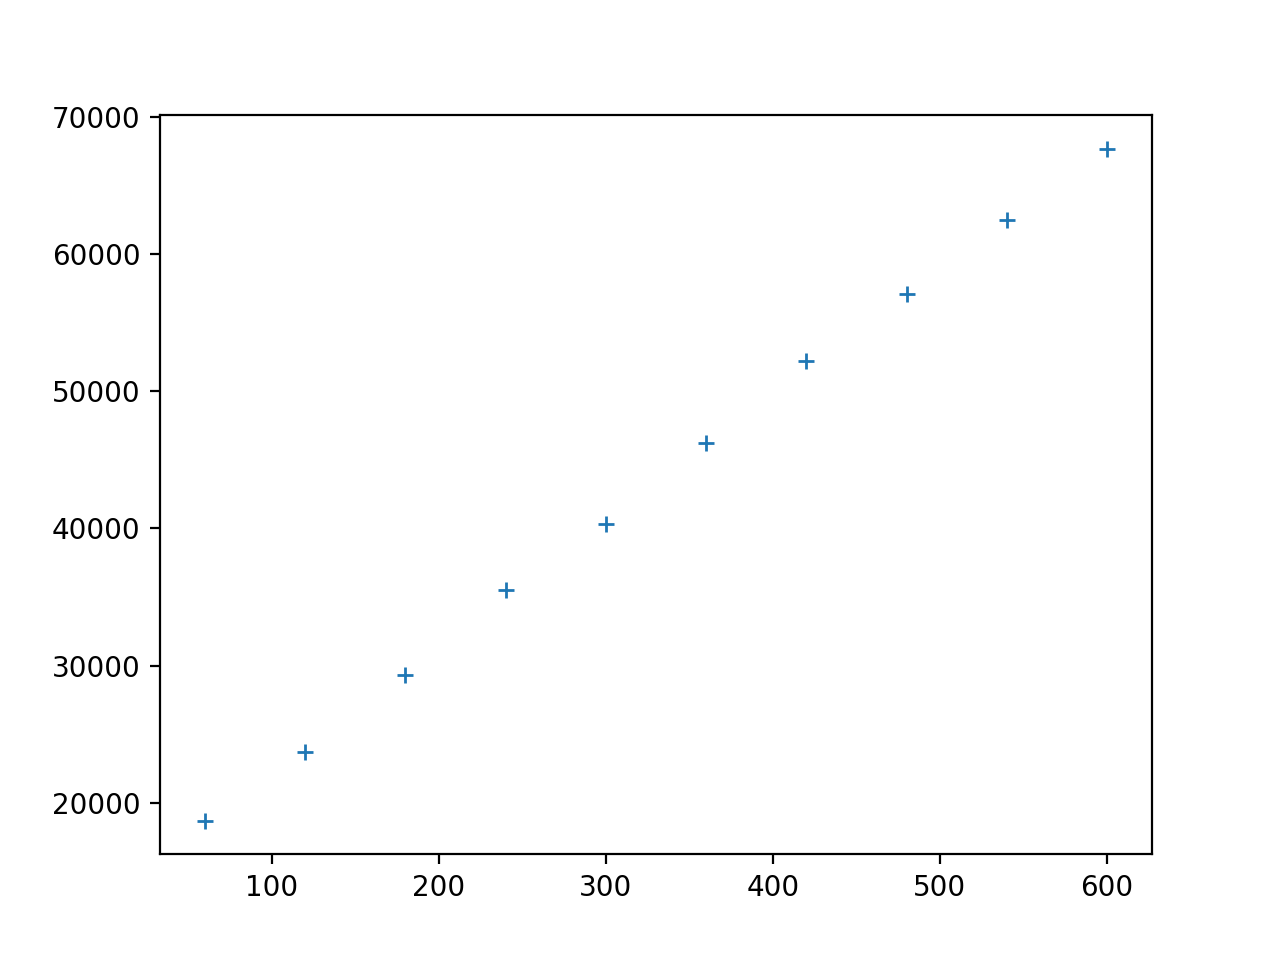

In [168]:
plt.figure()
plt.plot(freqs, counts, '+')